<a href="https://colab.research.google.com/github/adityatanwar15/Sentiment_Analysis_twitter/blob/master/sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
!python -m textblob.download_corpora
import nltk
nltk.download('stopwords')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
Finished.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
!pip install kaggle


In [0]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"adityatanwar15","key":"27a84026da8551892bb8b23a7815521d"}'}

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle

In [0]:
!kaggle datasets download -d arkhoshghalb/twitter-sentiment-analysis-hatred-speech

  0% 0.00/1.89M [00:00<?, ?B/s]
100% 1.89M/1.89M [00:00<00:00, 63.5MB/s]


In [0]:
!unzip twitter-sentiment-analysis-hatred-speech.zip

Archive:  twitter-sentiment-analysis-hatred-speech.zip
  inflating: test.csv                
  inflating: train.csv               


In [0]:
train_tweets = pd.read_csv('train.csv')
test_tweets = pd.read_csv('test.csv')


In [0]:
train_tweets= train_tweets[['label','tweet']]
test = test_tweets['tweet']

Data analysis

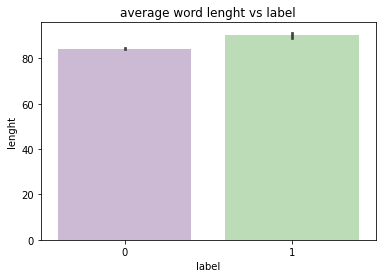

In [0]:
train_tweets['lenght']=train_tweets['tweet'].apply(len)
fig1= sns.barplot('label','lenght',data=train_tweets,palette='PRGn')
plt.title('average word lenght vs label')
plot= fig1.get_figure()
plot.savefig('barplot.png')

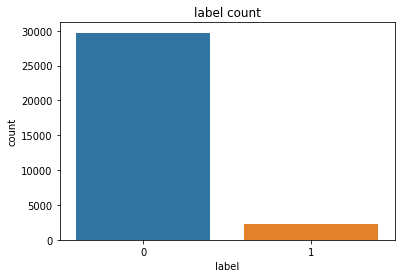

In [0]:
fig2=sns.countplot(x='label', data=train_tweets)
plt.title('label count')
plot=fig2.get_figure()
plot.savefig('count plot.png')

Feature Engineering

In [0]:
def text_processing(tweet):
  #generating the list of the words in the tweet (hashtags and other puntuations removed)
  def form_sentence(tweet):
    tweet_blob=TextBlob(tweet)
    return ' '.join(tweet_blob.words)
  new_tweet = form_sentence(tweet)
  #removing stopwords and word with unusual symbols
  def no_user_alpha(tweet):
    tweet_list = [ele for ele in tweet.split() if ele != 'user']
    clean_tokens = [t for t in tweet_list if re.match(r'[^\W\d]*$', t)] 
    clean_s = ' '.join(clean_tokens)
    clean_mess = [word for word in clean_s.split() if word.lower() not in stopwords.words('english')]
    return clean_mess
  no_punc_tweet = no_user_alpha(new_tweet)
  #normalizing the words in tweet
  def normalization(tweet_list):
    lem = WordNetLemmatizer()
    normalized_tweet=[]
    for word in tweet_list:
      normalized_text = lem.lemmatize(word, 'v')
      normalized_tweet.append(normalized_text)
    return normalized_tweet
  return normalization(no_punc_tweet)



In [0]:
train_tweets['tweet_list'] = train_tweets['tweet'].apply(text_processing)
test_tweets['tweet_list'] = test_tweets['tweet'].apply(text_processing)

In [0]:
train_tweets[train_tweets['label']==1].drop('tweet',axis=1).head()

,label,lenght,tweet_list
13,1,74,"[cnn, call, michigan, middle, school, wall, ch..."
14,1,101,"[comment, australia, opkillingbay, seashepherd..."
17,1,22,"[retweet, agree]"
23,1,47,"[lumpy, say, prove, lumpy]"
34,1,104,"[unbelievable, century, need, something, like,..."


Model selection and machine learning

In [0]:
X= train_tweets['tweet']
y = train_tweets['label']
test =test_tweets['tweet']

In [0]:
from sklearn.model_selection import train_test_split
msg_train, msg_test, label_train, label_test=train_test_split(X,y, test_size=.2)

In [0]:
#machine learninng pipeline
pipeline=Pipeline([('bow', CountVectorizer(analyzer=text_processing)),
                   ('tfidf', TfidfTransformer()),
                   ('classifier', MultinomialNB())
                   ])
pipeline.fit(msg_train, label_train)


Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer=<function text_processing at 0x7f9d9d5fc378>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [0]:
predictions=pipeline.predict(msg_test)
print(classification_report(predictions,label_test))
print('\n')
print(confusion_matrix(predictions, label_test))
print(accuracy_score(predictions, label_test))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97      6326
           1       0.15      1.00      0.26        67

    accuracy                           0.94      6393
   macro avg       0.57      0.97      0.61      6393
weighted avg       0.99      0.94      0.96      6393



[[5935  391]
 [   0   67]]
0.9388393555451274
